Changes:- 
loaded dataset using pytorch.
used only 600 images for training.


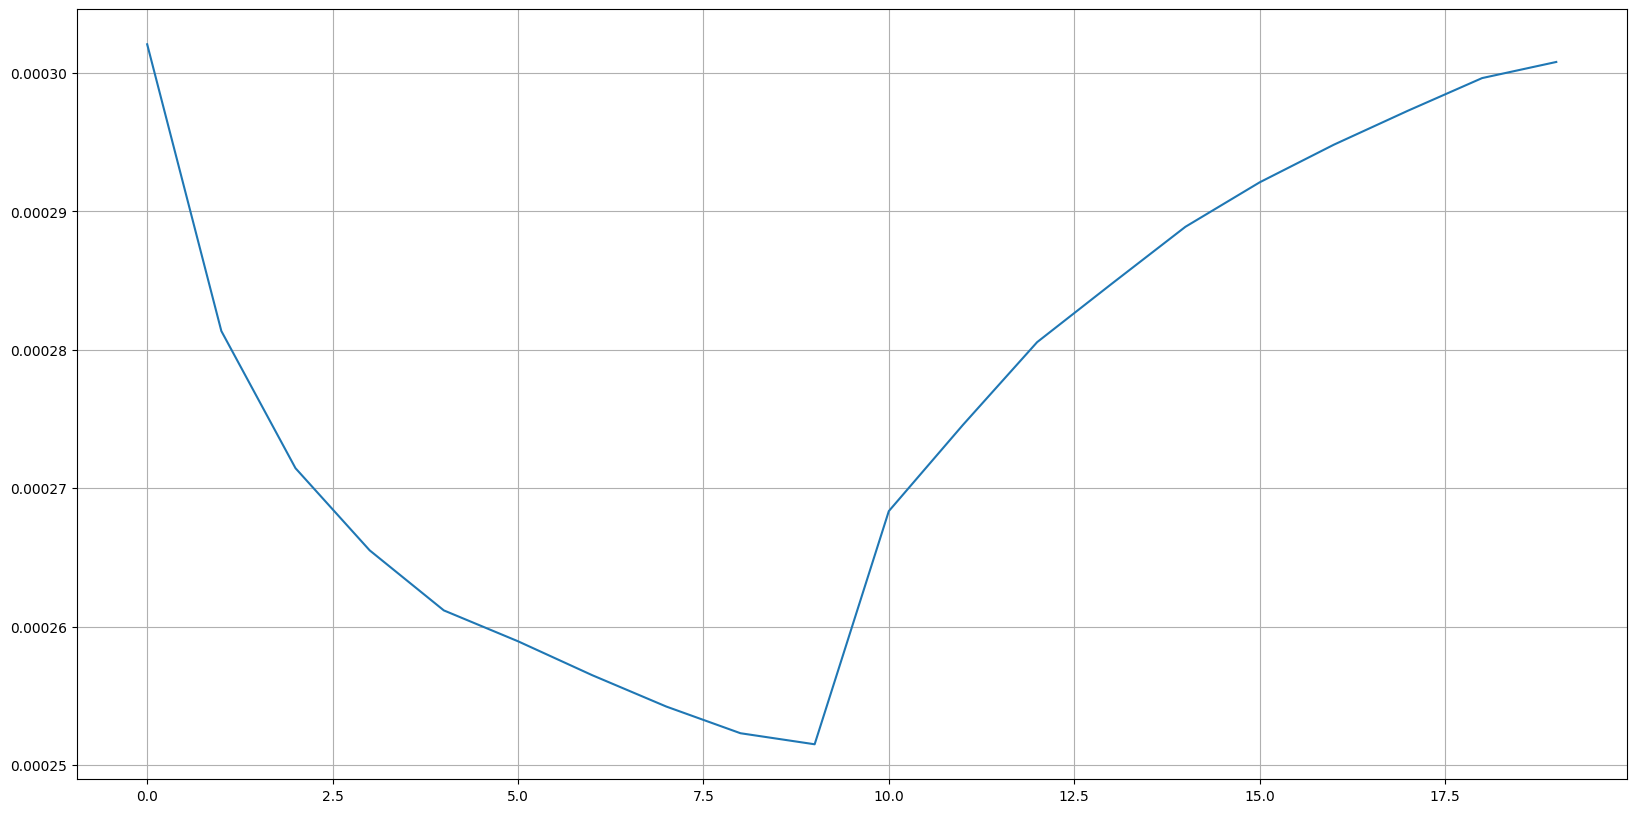

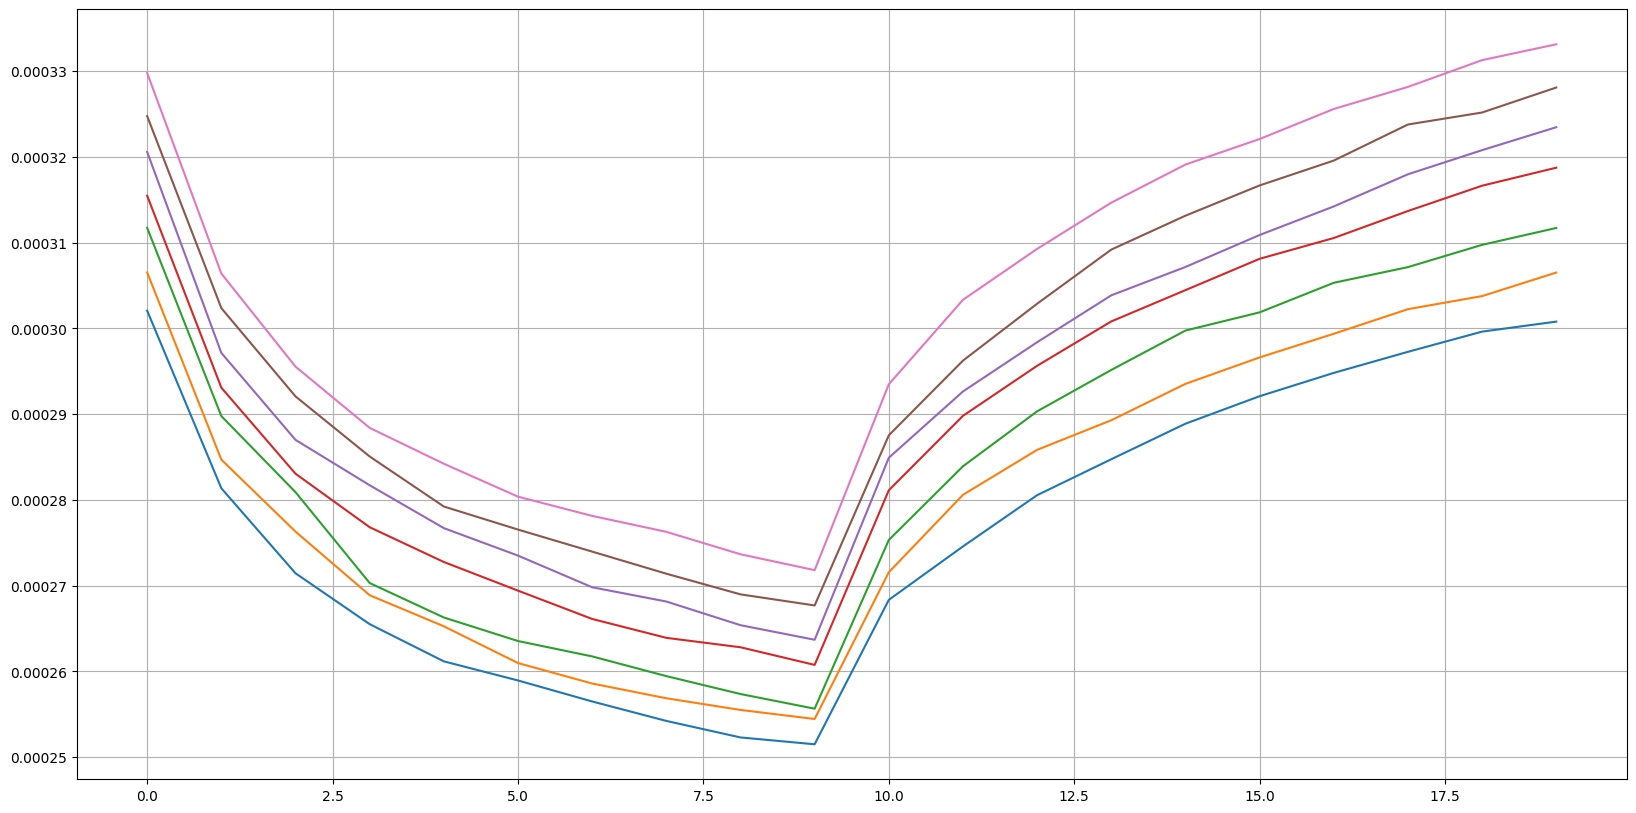

In [2]:
import scipy.io
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import torchvision
import matplotlib.pyplot as plt
from torchvision import datasets, transforms

data1 = scipy.io.loadmat(r"JE1504_10u_r4c4_50_ohm_pot_dep_at_23-01-2024_17-39-54final_data_10.mat")
data2 = scipy.io.loadmat(r"JE1504_10u_r4c4_50_ohm_pot_dep_at_23-01-2024_17-46-44final_data_10.mat")
data3 = scipy.io.loadmat(r"JE1504_10u_r4c4_50_ohm_pot_dep_at_23-01-2024_17-53-02final_data_10.mat")
data1 = data1['combined_data']
data2 = data2['combined_data']
data3 = data3['combined_data']
# print the shape of the data

# reduce dimensionality of the data
data1 = np.squeeze(data1)
data2 = np.squeeze(data2)
data3 = np.squeeze(data3)

plt.figure(figsize=(20, 10))
plt.grid()
plt.plot(data1)
plt.show()

# lengths of data1 2 and 3 are multiples of 20. So we can reshape them to 20xN
data1 = data1.reshape(-1, 20)
data2 = data2.reshape(-1, 20)
data3 = data3.reshape(-1, 20)

# concatenate the data1, data2 and data3
data = np.concatenate((data1, data2, data3), axis=0)

# plot all rows of concatenated data
plt.figure(figsize=(20, 10))
plt.grid()
for i in range(data.shape[0]):
    plt.plot(data[i])
plt.show()



In [3]:
scaled_data = (data - 0.000256) / (0.000302 - 0.000256)
scaled_data = scaled_data


In [4]:
import random


class PCM_device_look_up:

    def __init__(self, scaled_data):
        # select random row of scaled_data
        # Randomly select a row from scaled_data
        self.scaled_data = scaled_data
        # self.cycle_data = random.choice(self.scaled_data)
        self.cycle_data = self.scaled_data[1]  # Using single device currently
        # Initialize scaled_conductance as cycle_data[9]
        self.cycle_data_index = random.choice([0, 1, 4, 5, 9, 12, 15])

    def increment(self):
        # if index is from 9 to 18, increment it by 1
        # if index is from 0 to 8, find another index in 9 to 19 such that the new cycle_data value is smallest greater value than previous
        if self.cycle_data_index >=9 and self.cycle_data_index <= 18:
            self.cycle_data_index +=1
        elif self.cycle_data_index <= 8:
            current_value = self.cycle_data[self.cycle_data_index]
            i = 9
            while self.cycle_data[i] <= self.cycle_data[self.cycle_data_index]:
                i += 1
                if i == 19:
                    break
            self.cycle_data_index = i
        else:
            pass

    def decrement(self):

        if self.cycle_data_index >=10:
            current_value = self.cycle_data[self.cycle_data_index]
            i = 0
            while self.cycle_data[i] >= self.cycle_data[self.cycle_data_index]:
                i += 1
                if i == 9:
                    break
            self.cycle_data_index = i

        elif self.cycle_data_index <= 8:
            self.cycle_data_index +=1

        else:
            pass

    def conduct(self):
        # Return the current conductance value
        return self.cycle_data[self.cycle_data_index]

    def reset(self):
        # Reset the cycle_data_index to the initial value
        self.cycle_data_index = 9
        # self.cycel_data = random.choice(self.scaled_data)

    def hard_set(self):
        # Reset the cycle_data_index to the initial value
        self.cycle_data_index = 19
        # self.cycel_data = random.choice(self.scaled_data)


class PCM_device_composite_look_up:
    def __init__(self,scaled_data, N, scaling_coefficients_list = [1]):
        # print(len(scaling_coefficients_list))
        # sort the scaling coefficients in ascending order
        scaling_coefficients_list = np.sort(scaling_coefficients_list)
        # Scaling Coefficients = [Least Significant, 2nd Least Significant, ..., Most Significant]
        if(len(scaling_coefficients_list) != N):
            raise ValueError("Number of weights should be equal to number of devices")
        self.scaling_coefficients = scaling_coefficients_list
        self.N = N

        # Now we have the solution. We will use this solution to initialize the weights of the devices
        self.PCM_devices = [PCM_device_look_up(scaled_data) for i in range(N)]
        self.cutoff_zone_d = 0.95
        self.cutoff_zone_p = 0.05

        # Weight of composite device is weighted sum of weights of individual devices
        self.device_weight_list = [device.conduct() for device in self.PCM_devices]
        self.total_weight = np.sum(np.array(self.scaling_coefficients) * np.array(self.device_weight_list))

    def increment(self):
        # implement binary counting. If device i is in zone d, reset it and increment device i+1
        i = 0
        j = 0
        k = 0

        while(j<self.N):
            if(self.PCM_devices[j].conduct() >= self.cutoff_zone_d):
                k += 1
            j+=1
        if k<self.N:
            while(i < self.N):
                if(self.PCM_devices[i].conduct() < self.cutoff_zone_d):
                    self.PCM_devices[i].increment()
                    break
                else:
                    i+=1
                    if(i==self.N):
                        break
                    else:
                        self.PCM_devices[i-1].reset()


    def decrement(self):
        # implement binary counting. If device i is in zone p, reset it and decrement device i+1
        # implement binary counting. If device i is in zone d, reset it and increment device i+1
        i = 0
        j = 0
        k = 0

        while(j<self.N):
            if(self.PCM_devices[j].conduct() <= self.cutoff_zone_p):
                k += 1
            j+=1
        if k<self.N:
            while(i < self.N):
                if(self.PCM_devices[i].conduct() > self.cutoff_zone_p):
                    self.PCM_devices[i].decrement()
                    break
                else:
                    i+=1
                    if(i==self.N):
                        break
                    else:
                        self.PCM_devices[i-1].hard_set()

    def total_composite_weight(self):
        self.device_weight_list = [device.conduct() for device in self.PCM_devices]
        self.total_weight = np.sum(np.array(self.scaling_coefficients) * np.array(self.device_weight_list))
        return torch.tensor(self.total_weight)


In [7]:
class MyModel(nn.Module):
    def __init__(self):
        super(MyModel, self).__init__()
        self.fc1 = nn.Linear(784, 250, bias = True)
        self.fc2 = nn.Linear(250, 10, bias = True)

    def forward(self, x):
        x1 = F.relu(self.fc1(x))
        x2 = self.fc2(x1)
        # x3 = F.softmax(x2)
        return x2

# Initialize the model
model = MyModel()
# Define the loss function
loss_fn = nn.CrossEntropyLoss()
# loss_fn = nn.MSELoss

# Define the optimizer
optimizer = optim.SGD(model.parameters(), lr=0.1)

In [8]:
print(model)

MyModel(
  (fc1): Linear(in_features=784, out_features=250, bias=True)
  (fc2): Linear(in_features=250, out_features=10, bias=True)
)


In [9]:
from torchvision import datasets, transforms
transform = transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((0.5,), (0.5,)),
                              ])
# transform = transforms.Compose([transforms.ToTensor(),
#                               ])

In [11]:
# trainset = datasets.MNIST('PATH_TO_STORE_TRAINSET', download=True, train=True, transform=transform)
# valset = datasets.MNIST('PATH_TO_STORE_TESTSET', download=True, train=False, transform=transform)
# trainloader = torch.utils.data.DataLoader(trainset, batch_size=256, shuffle=True)
# valloader = torch.utils.data.DataLoader(valset, batch_size=256, shuffle=True)

In [7]:
# import tensorflow as tf
# from torch.utils.data import DataLoader, Dataset

# # Define the dataset class
# class MNISTDataset(Dataset):
#     def __init__(self, x, y):
#         self.x = x.astype(np.float32)
#         # print(x)
#         self.y = y.astype(np.int64)
#         # print(y)

#     def __len__(self):
#         return len(self.x)

#     def __getitem__(self, idx):
#         return self.x[idx], self.y[idx]


# # load mnist dataset from web
# mnist = tf.keras.datasets.mnist
# (x_train, y_train), (x_test, y_test) = mnist.load_data()
# # print("Mean", np.mean(x_train))
# x_train, x_test = x_train / 255.0, x_test / 255.0
# # print("Mean", np.mean(x_train))

# x_train = x_train.astype(np.float32)
# x_test = x_test.astype(np.float32)
# y_train = y_train.astype(np.int64)
# y_test = y_test.astype(np.int64)
# # Reshape the data
# x_train = x_train.reshape(-1, 784)
# x_test = x_test.reshape(-1, 784)


# optimizer = optim.Adam(model.parameters(), lr=0.01)
# criterion = nn.CrossEntropyLoss()
# # print("Mean", np.mean(x_train))
# train_dataset = MNISTDataset(x_train, y_train)
# # limit epochs to 2
# train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

# val_dataset = MNISTDataset(x_test, y_test)
# val_loader = DataLoader(val_dataset, batch_size=64, shuffle=True)


In [10]:
import torch
from torch.utils.data import DataLoader, SubsetRandomSampler
from torchvision import datasets, transforms

# Define the transformation to convert data to tensors
transform = transforms.ToTensor()

# Load the MNIST dataset
full_train_dataset = datasets.MNIST(root="data", train=True, download=True, transform=transform)
test_data = datasets.MNIST(root="data", train=False, download=True, transform=transform)

# Create a smaller training dataset with only 600 images
train_size = 600
indices = list(range(len(full_train_dataset)))
np.random.shuffle(indices)
subset_indices = indices[:train_size]
train_sampler = SubsetRandomSampler(subset_indices)
train_loader = DataLoader(full_train_dataset, batch_size=64, sampler=train_sampler)


# Create a test dataset with 100 images
test_size = 100
test_indices = indices[train_size:train_size+test_size]
test_sampler = SubsetRandomSampler(test_indices)
test_loader = DataLoader(full_train_dataset, batch_size=64, sampler=test_sampler)

# Create data loaders for training and testing
#train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
#test_loader = DataLoader(test_data, batch_size=64, shuffle=False)

## Print dataset information
#print(f"Number of training samples: {len(train_data)}")
#print(f"Number of test samples: {len(test_data)}")
#print(f"Number of classes: {len(train_data.classes)}")


Failed to download (trying next):
HTTP Error 503: Service Unavailable



100.0%


Extracting data\MNIST\raw\train-images-idx3-ubyte.gz to data\MNIST\raw



100.0%


Extracting data\MNIST\raw\train-labels-idx1-ubyte.gz to data\MNIST\raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable



100.0%


Extracting data\MNIST\raw\t10k-images-idx3-ubyte.gz to data\MNIST\raw



100.0%

Extracting data\MNIST\raw\t10k-labels-idx1-ubyte.gz to data\MNIST\raw



In [11]:
sum = 0
for x,y in train_loader:
  sum += np.sum(x.numpy())
print(sum)
# np.asarry(t)

63061.14599609375


In [12]:
devices_layer_1 = []
devices_layer_2 = []

weight_grad1 = np.zeros((250,784))
weight_grad2 = np.zeros((10,250))


for i in range(weight_grad1.shape[0]):
  row_wise_list = []
  for j in range(weight_grad1.shape[1]):
    row_wise_list.append(PCM_device_composite_look_up(scaled_data = scaled_data, N = 3, scaling_coefficients_list = [0.1,1,10]))
  devices_layer_1.append(row_wise_list)


for i in range(weight_grad2.shape[0]):
  row_wise_list = []
  for j in range(weight_grad2.shape[1]):
    row_wise_list.append(PCM_device_composite_look_up(scaled_data = scaled_data, N = 3, scaling_coefficients_list = [0.1,1,10]))
  devices_layer_2.append(row_wise_list)

devices = []
devices.append(devices_layer_1)
devices.append(devices_layer_2)


In [13]:
# use cuda if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [14]:
# Calculate accuracy (a classification metric)
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item() # torch.eq() calculates where two tensors are equal
    acc = (correct / len(y_pred)) * 100 
    return acc

In [27]:
#Lets profile the code to see how much time it takes to run
import time
start = time.time()

%prun
# Define the number of epochs
n_epochs = 5

q = 0
for images,labels in train_loader:
  if q < 1:
    # print("Mean", np.mean(images))
    # print(1000*images)
    print("Batch", q)
    q+=1
    for steps in range(1):
        # print(images.view(images.shape[0],-1).shape)
        x = images.view(images.shape[0],-1) # 64 images
        x_numpy = x.numpy()
        # print(np.sum(x_numpy))
        optimizer.zero_grad()
        y_pred = model(x)
        y_logi = torch.round(torch.sigmoid(y_pred))
        loss = loss_fn(y_pred,labels)
    
    
        #accuracy calculation
        _, pred_lebel = torch.max(y_pred,1)
        total = y_pred.shape[0]
        correct = (pred_lebel==labels).sum().item()
        acc = (correct/total)*100
        
        #print(loss)
        print(f"steps: {steps} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% ")
        loss.backward()
        weight_grad1 = model.fc1.weight.grad
        weight_grad2 = model.fc2.weight.grad
        numpy_wgrad1 = weight_grad1.detach().numpy()
        # print("Sum = ",np.sum(numpy_wgrad1))

        new_weight1 = torch.zeros(weight_grad1.shape)
        new_weight2 = torch.zeros(weight_grad2.shape)
        # print(weight_grad2.nonzero)
        # print(1e9*weight_grad2)
        # Bhai increment and decrement ulta nahi hoga?
        # weight update normally weight - learning_rate*gradient hota hai
        for i in range(weight_grad1.shape[0]):
            for j in range(weight_grad1.shape[1]):
                if(weight_grad1[i][j]>=0):
                    devices[0][i][j].decrement()
                # print("Gradient is 0")
                else:
                # print("abdkjanbckejblwnfqjqknajojojojjqjklnkql")
                    devices[0][i][j].increment()
                new_weight1[i][j] = devices[0][i][j].total_composite_weight()

        for i in range(weight_grad2.shape[0]):
            for j in range(weight_grad2.shape[1]):
                if(weight_grad2[i][j]>=0):
                # print("Gradient is 0")
                    devices[1][i][j].decrement()
                else:
                # print("abdkjanbckejblwnfqjqknajojojojjqjklnkql")
                    devices[1][i][j].increment()
                new_weight2[i][j] = devices[1][i][j].total_composite_weight()

        model.fc1.weight.data = new_weight1
        model.fc2.weight.data = new_weight2

    

end = time.time()
print(f"Total time taken: {end-start} seconds")





 Batch 0
steps: 0 | Loss: 27279.94336, Accuracy: 12.50% 
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
Sum =  5391.6387


KeyboardInterrupt: 

         3 function calls in 0.000 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.000    0.000    0.000    0.000 {built-in method builtins.exec}
        1    0.000    0.000    0.000    0.000 <string>:1(<module>)
        1    0.000    0.000    0.000    0.000 {method 'disable' of '_lsprof.Profiler' objects}

In [15]:
q = 0
for images,labels in train_loader:
  # print("Mean", np.mean(images))
  # print(1000*images)
  print("Batch", q)
  q+=1
  for steps in range(50):
    # print(images.view(images.shape[0],-1).shape)
    x = images.view(images.shape[0],-1) # 64 images
    x_numpy = x.numpy()
    # print(np.sum(x_numpy))
    optimizer.zero_grad()
    y_pred = model(x)
    y_logi = torch.round(torch.sigmoid(y_pred))
    loss = loss_fn(y_pred,labels)
  
  
    #accuracy calculation
    _, pred_lebel = torch.max(y_pred,1)
    total = y_pred.shape[0]
    correct = (pred_lebel==labels).sum().item()
    acc = (correct/total)*100
    
    #print(loss)
    print(f"steps: {steps} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% ")
    loss.backward()
    optimizer.step()
    weight_grad1 = model.fc1.weight.grad
    weight_grad2 = model.fc2.weight.grad
    new_weight1 = torch.zeros(weight_grad1.shape)
    new_weight2 = torch.zeros(weight_grad2.shape)
    # print(weight_grad2.nonzero)
    # print(1e9*weight_grad2)
    # Bhai increment and decrement ulta nahi hoga?
    # weight update normally weight - learning_rate*gradient hota hai
    for i in range(weight_grad1.shape[0]):
      for j in range(weight_grad1.shape[1]):
        if(weight_grad1[i][j]>=0):
          devices[0][i][j].decrement()
          # print("Gradient is 0")
        else:
          # print("abdkjanbckejblwnfqjqknajojojojjqjklnkql")
          devices[0][i][j].increment()
        new_weight1[i][j] = devices[0][i][j].total_composite_weight()

    for i in range(weight_grad2.shape[0]):
      for j in range(weight_grad2.shape[1]):
        if(weight_grad2[i][j]>=0):
          # print("Gradient is 0")
          devices[1][i][j].decrement()
        else:
          # print("abdkjanbckejblwnfqjqknajojojojjqjklnkql")
          devices[1][i][j].increment()
        new_weight2[i][j] = devices[1][i][j].total_composite_weight()

    model.fc1.weight.data = new_weight1
    model.fc2.weight.data = new_weight2

    

0
steps: 0 | Loss: 2.32058, Accuracy: 4.69% 
steps: 1 | Loss: 47129.92188, Accuracy: 14.06% 
steps: 2 | Loss: 42345.58984, Accuracy: 14.06% 
steps: 3 | Loss: 35961.66406, Accuracy: 15.62% 
steps: 4 | Loss: 30267.39844, Accuracy: 10.94% 
steps: 5 | Loss: 27835.79297, Accuracy: 10.94% 
steps: 6 | Loss: 27548.65625, Accuracy: 15.62% 


KeyboardInterrupt: 

In [16]:
model.eval()
eval_total = 0
eval_correct = 0
with torch.no_grad():
    for inputs, labels in test_loader:
            outputs = model(inputs.view(inputs.shape[0], -1))
            _, predicted = torch.max(outputs, 1)
            eval_total += outputs.shape[0]
            eval_correct += (predicted == labels).sum().item() # Compare item() instead of using sum()
    accuracy = (eval_correct/eval_total)*100
    print(f'Test Accuracy: {accuracy:.4f}')

Test Accuracy: 12.0000


In [ ]:
# import threading

# # Lets use multi prthreading to update the weights
# # Define the function to update the weights


# def parallel_update_weights(weight_grad, devices):
#     # Create a new weight tensor
#     new_weight = torch.zeros(weight_grad.shape)

#     # Create a list of threads
#     threads = []

#     # Iterate over the weight tensor
#     for i in range(weight_grad.shape[0]):
#         for j in range(weight_grad.shape[1]):
#             # Create a thread for each device
#             t = threading.Thread(target=update_weight, args=(i, j, weight_grad, devices, new_weight))
#             threads.append(t)

#     # Start the threads
#     for t in threads:
#         t.start()

#     # Join the threads
#     for t in threads:
#         t.join()

#     return new_weight

# def update_weight(i, j, weight_grad, devices, new_weight):

#     # Check if the weight gradient is positive
#     if weight_grad[i][j] >= 0:
#         devices[i][j].decrement()
#     else:
#         devices[i][j].increment()

#     # Update the new weight
#     new_weight[i][j] = devices[i][j].total_composite_weight()

#     return

# # Define the training loop
# def train_loop(train_loader, model, loss_fn, optimizer, devices):
#     for images, labels in train_loader:
#         # Flatten the images batch for processing
#         x = images.view(images.shape[0], -1)


#         for steps in range(50):
#             # Zero the gradients
#             optimizer.zero_grad()

#             # Forward pass
#             y_pred = model(x)

#             # Compute the loss
#             loss = loss_fn(y_pred, labels)
#             print(loss)

#             # Backward pass
#             loss.backward()

#             # For fc1 weights
#             weight_grad1 = model.fc1.weight.grad
#             new_weight1 = parallel_update_weights(weight_grad1, devices[0])
#             model.fc1.weight.data = new_weight1

#             # For fc2 weights
#             weight_grad2 = model.fc2.weight.grad
#             new_weight2 = parallel_update_weights(weight_grad2, devices[1])
#             model.fc2.weight.data = new_weight2

#     return

# # Train the model
# train_loop(train_loader, model, loss_fn, optimizer, devices)







tensor(972.9717, grad_fn=<NllLossBackward0>)
tensor(597.7061, grad_fn=<NllLossBackward0>)
tensor(1025.2212, grad_fn=<NllLossBackward0>)


KeyboardInterrupt: 

In [ ]:
# # using multiprocessing
# import concurrent.futures

# def parallel_update_weights(weight_grad, devices):
#     # Create a new weight tensor
#     new_weight = torch.zeros(weight_grad.shape)

#     # Create a list of tasks
#     tasks = []

#     # Iterate over the weight tensor
#     for i in range(weight_grad.shape[0]):
#         for j in range(weight_grad.shape[1]):
#             # Create a task for each device
#             tasks.append((i, j, weight_grad, devices, new_weight))

#     # Create a process pool and run the tasks
#     with concurrent.futures.ProcessPoolExecutor() as executor:
#         executor.map(update_weight, tasks)

#     return new_weight

# def update_weight(task):
#     i, j, weight_grad, devices, new_weight = task

#     # Check if the weight gradient is positive
#     if weight_grad[i][j] >= 0:
#         devices[i][j].decrement()
#     else:
#         devices[i][j].increment()

#     # Update the new weight
#     new_weight[i][j] = devices[i][j].total_composite_weight()

#     return

# # Define the training loop
# def train_loop(train_loader, model, loss_fn, optimizer, devices):
#     for images, labels in train_loader:
#         # Flatten the images batch for processing
#         x = images.view(images.shape[0], -1)

#         for steps in range(50):
#             # Zero the gradients
#             optimizer.zero_grad()

#             # Forward pass
#             y_pred = model(x)

#             # Compute the loss
#             loss = loss_fn(y_pred, labels)
#             print(loss)
#             # Backward pass
#             loss.backward()

#             # For fc1 weights
#             weight_grad1 = model.fc1.weight.grad
#             new_weight1 = parallel_update_weights(weight_grad1, devices[0])
#             model.fc1.weight.data = new_weight1

#             # For fc2 weights
#             weight_grad2 = model.fc2.weight.grad
#             new_weight2 = parallel_update_weights(weight_grad2, devices[1])
#             model.fc2.weight.data = new_weight2

#     return

# # Train the model
# train_loop(train_loader, model, loss_fn, optimizer, devices)

tensor(2.2751, grad_fn=<NllLossBackward0>)
tensor(2.3040, grad_fn=<NllLossBackward0>)


In [ ]:
# print total_composite_weight of all devices
weights_layer_1 = []
for i in range(250):
    for j in range(784):
        weights_layer_1.append(devices[0][i][j].total_composite_weight().detach().numpy().item())

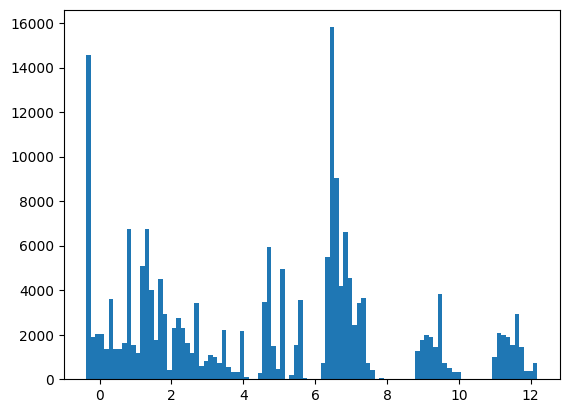

In [ ]:
# plot the distribution of total_weight
plt.hist(weights_layer_1, bins=100)
plt.show()


In [ ]:
print(weights_layer_1[0:100])

[6.5017447691998935, 6.39034445517482, 1.3321376064567751, 4.7049576189679465, 4.677783430148897, 4.62103598479312, 0.8270002336221927, 4.738273202831757, 5.100174702057538, 1.3279854303773289, 1.2485515186005893, 6.5017447691998935, -0.3146355522337725, 6.455993725047208, 6.483505155809383, 0.7412941776052803, 6.40858406856533, 6.483505155809383, -0.3146355522337725, 5.5227160696220015, -0.3146355522337725, 0.8270002336221927, 4.756512816222267, 3.961613747574602, 6.455993725047208, 6.39034445517482, 0.7812491894695077, 1.2968011620127133, 0.5012990396017378, 0.8270002336221927, 0.92369031151038, 6.483505155809383, 4.677783430148897, 3.961613747574602, 1.1963168977774987, 5.574271266876322, 5.0434272567017615, -0.3146355522337725, 4.738273202831757, 0.8270002336221927, 0.9057296196955631, 5.574271266876322, 1.1963168977774987, 6.40858406856533, 5.574271266876322, 5.100174702057538, 3.092300099666226, 6.40858406856533, 6.5017447691998935, 4.533067532260013, 0.7702527882664156, 5.522716